In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import random, numpy as jnp
from pc2 import Network, Module, Dense, Sequential
import datasets
from PIL import Image
import matplotlib.pyplot as plt
# from clu import metrics
import flax
import flax.linen as nn
import datasets
import numpy.random as npr


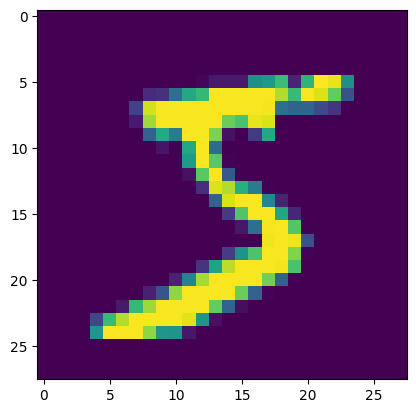

In [2]:
train_images, train_labels, test_images, test_labels = datasets.mnist()
plt.imshow(jnp.reshape(train_images[0], (28,28)))


In [3]:
# batch_size = 4096
batch_size = 60000
train_images, train_labels, test_images, test_labels = datasets.mnist()
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield train_images[batch_idx], train_labels[batch_idx]
batches = data_stream()


In [4]:
class MLP(nn.Module):

    @nn.compact
    def __call__(self, x, params=None, x_i=None):
        if params is None:
            x1 = nn.Dense(1024)(x)
        else:
            x1 = nn.Dense(
                features=1024,
                kernel_init=lambda r,s,d:params['Dense_0']['kernel'],
                bias_init=lambda r,s,d:params['Dense_0']['bias'])(x)
        if x_i is None:
            x_1 = self.variable('x_i', 'x_1', lambda s:x1, x1.shape).value
        else:
            x_1 = self.variable('x_i', 'x_1', lambda s:x_i['x_1'], x1.shape).value
        x2 = nn.tanh(x_1)
        if params is None:
            x2 = nn.Dense(256)(x2)
        else:
            x2 = nn.Dense(
                features=256,
                kernel_init=lambda r,s,d:params['Dense_1']['kernel'],
                bias_init=lambda r,s,d:params['Dense_1']['bias'])(x2)
        if x_i is None:
            x_2 = self.variable('x_i', 'x_2', lambda s:x2, x2.shape).value
        else:
            x_2 = self.variable('x_i', 'x_2', lambda s:x_i['x_2'], x2.shape).value
        x3 = nn.tanh(x_2)
        if params is None:
            x3 = nn.Dense(10)(x3)
        else:
            x3 = nn.Dense(
                features=10,
                kernel_init=lambda r,s,d:params['Dense_2']['kernel'],
                bias_init=lambda r,s,d:params['Dense_2']['bias'])(x3)
        # y = nn.sigmoid(y)
        # x_3 = self.variable('x_i', 'x_3', lambda s:x3, x3.shape).value
        y = x3
        # y = nn.activation.softmax(x3)
        # y = nn.activation.softmax(nn.Dense(10)(x_2))
        energy_i = 0.5 * jnp.sum((x_1 - x1) ** 2, axis=-1) \
            + 0.5 * jnp.sum((x_2 - x2) ** 2, axis=-1)
            # + 0.5 * jnp.sum((x_3 - x3) ** 2, axis=-1)
        return y, energy_i

    # def forward(self, x):
    #     theta_0 = self.get_variable('params', 'Dense_0')
    #     x1 = nn.tanh(jnp.einsum('io,bi->bo', theta_0['kernel'], x) + theta_0['bias'])
    #     self.put_variable('x_i', 'x_1', x1)
    #     theta_y = self.get_variable('params', 'Dense_1')
    #     y = jnp.einsum('io,bi->bo', theta_y['kernel'], x1) + theta_y['bias']
    #     y = nn.activation.softmax(y)
    #     return y


model = MLP()

In [5]:
key1, key2 = random.split(random.key(0))
train_size=123
x = train_images[0:train_size]
y = train_labels[0:train_size]
print(x.shape, y.shape)
variables = model.init(key2, x) # Initialization call
jax.tree_util.tree_map(lambda x: x.shape, variables) # Checking output shapes

(123, 784) (123, 10)


{'params': {'Dense_0': {'bias': (1024,), 'kernel': (784, 1024)},
  'Dense_1': {'bias': (256,), 'kernel': (1024, 256)},
  'Dense_2': {'bias': (10,), 'kernel': (256, 10)}},
 'x_i': {'x_1': (123, 1024), 'x_2': (123, 256)}}

In [6]:
model.apply(variables, x)


(Array([[ 0.20096423, -0.10347247, -0.12391065, ...,  0.010079  ,
         -0.03895447,  0.42509848],
        [-0.16252688, -0.63284254,  0.22300434, ..., -0.1674048 ,
          0.01670596,  0.32655436],
        [-0.08711608,  0.23115249, -0.05082002, ...,  0.13774824,
         -0.01776063,  0.16905132],
        ...,
        [ 0.03562766, -0.33517   ,  0.1174432 , ...,  0.10736018,
         -0.2692725 ,  0.75354725],
        [ 0.01970679, -0.45986646,  0.11544465, ..., -0.12386569,
          0.2058376 ,  0.345915  ],
        [ 0.11853416,  0.21142189,  0.48370102, ..., -0.3398654 ,
          0.27095622,  0.4789226 ]], dtype=float32),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [7]:
# Same as JAX version but using model.apply().
# @jax.jit
def energy_fn_(theta, x_i, x_batched, y_batched, alpha=1.0):
  # def cross_entropy(x, y):
  pred, energy_i = model.apply({'params': theta, 'x_i': x_i}, x_batched, x_i=x_i)
  # cse = -jnp.sum(y * jnp.log(pred), axis=-1)
  mse = 0.5 * jnp.sum((y - pred) ** 2, axis=-1)
  result = mse + alpha * energy_i
  # result = 0.5 * jnp.sum((pred - y) ** 2, axis=-1) + alpha * energy_i
  # print(f'result: {result.shape}, {jnp.mean(result, axis=0)}')
  # return result, cse, energy_i
  # energy = jnp.mean(jax.vmap(cross_entropy)(x_batched,y_batched), axis=0)
  # cse = jnp.mean(cse, axis=0)
  mse = jnp.mean(mse, axis=0)
  # print(f'cse: {cse.shape} {cse}')
  energy_i = jnp.mean(energy_i, axis=0)
  # print(f'energy_i: {energy_i.shape} {energy_i}')
  energy = jnp.mean(result, axis=0)
  # print(f'energy: {energy.shape}, {energy}')
  return energy, mse, energy_i

# @jax.jit
def energy_fn(theta, x_i, x_batched, y_batched, alpha=1.0):
  return energy_fn_(theta, x_i, x_batched, y_batched, alpha)[0]

In [8]:
def accuracy(variables, batch):
    inputs, targets = batch
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(model.apply(variables, inputs)[0], axis=1)
    return jnp.mean(predicted_class == target_class)


In [9]:
T = 100 # max IL iterations
eplison = 3e-4 # IL eplison
x_i_lr = 0.5  # Gradient step size for IL
theta_lr = 0.1 # Gradient step size for Theta
theta_grad_fn = jax.value_and_grad(energy_fn, argnums=0)
x_i_grad_fn = jax.value_and_grad(energy_fn, argnums=1)
print(theta_grad_fn, x_i_grad_fn)

# @jax.jit
def update_theta(theta, learning_rate, grads):
  theta = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, theta, grads)
  return theta

# @jax.jit
def update_x_i(x_i, learning_rate, grads):
  x_i = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, x_i, grads)
  return x_i

# x, y = next(batches)
# variables = model.init(key2, x)

# variables = model.init(key2, train_images, params=theta)
energy, mse, energy_i = energy_fn_(variables['params'], variables['x_i'], x, y)
print(f'energy: {energy}')
print(f'mse: {mse}')
print(f'energy_i: {energy_i}')


<function energy_fn at 0x7f7cac35d3a0> <function energy_fn at 0x7f7cac18c900>
energy: 0.8670310378074646
mse: 0.8670310378074646
energy_i: 0.0


In [10]:
theta = variables['params']
x_i = variables['x_i']

for step in range(501):
  # Perform one gradient update.
  for _ in range(num_batches):
    x, y = next(batches)
    variables = model.init(key2, x, params=theta)
    theta = variables['params']
    x_i = variables['x_i']
    start_energy = energy_fn(theta, x_i, x, y)
    prev_energy = start_energy
    for t, _ in enumerate(range(T)):
      prev_energy, grads = x_i_grad_fn(theta, x_i, x, y)
      x_i = update_x_i(x_i, x_i_lr, grads)
      # model.apply({'params': theta, 'x_i': x_i}, x)
      new_energy = energy_fn(theta, x_i, x, y)
      delta = abs(prev_energy - new_energy)
      # prev_energy = new_energy
      if delta/new_energy < eplison:
        print(f'IL energy: [{start_energy:.3e} => {new_energy:.3e}] ({t})')
        break
      if t == T-1:
        print(f'IL energy: [{start_energy:.3e} => {new_energy:.3e}] [end] ({t})')

    _, grads = theta_grad_fn(theta, x_i, x, y)
    theta = update_theta(theta, theta_lr, grads)


  if step % 1 == 0:
    print(f'Epoch {step}')
    variables = model.init(key2, train_images, params=theta)
    train_acc = accuracy(variables, (train_images, train_labels))
    variables = model.init(key2, test_images, params=theta)
    test_acc = accuracy(variables, (test_images, test_labels))
    print(f"Training set accuracy {train_acc*100:0.2f}%")
    print(f"Test set accuracy {test_acc*100:0.2f}%")


IL energy: [8.364e-01 => 8.364e-01] (0)
Epoch 0
Training set accuracy 15.18%
Test set accuracy 13.86%
IL energy: [6.335e-01 => 6.335e-01] (0)
Epoch 1
Training set accuracy 17.17%
Test set accuracy 15.95%
IL energy: [6.002e-01 => 6.002e-01] (0)
Epoch 2
Training set accuracy 19.77%
Test set accuracy 18.83%
IL energy: [5.717e-01 => 5.717e-01] (0)
Epoch 3
Training set accuracy 22.78%
Test set accuracy 21.71%
IL energy: [5.467e-01 => 5.467e-01] (0)
Epoch 4
Training set accuracy 25.59%
Test set accuracy 24.65%
IL energy: [5.248e-01 => 5.248e-01] (0)
Epoch 5
Training set accuracy 28.39%
Test set accuracy 27.58%
IL energy: [5.055e-01 => 5.055e-01] (0)
Epoch 6
Training set accuracy 31.03%
Test set accuracy 30.32%
IL energy: [4.884e-01 => 4.884e-01] (0)
Epoch 7
Training set accuracy 33.75%
Test set accuracy 33.16%
IL energy: [4.731e-01 => 4.731e-01] (0)
Epoch 8
Training set accuracy 36.21%
Test set accuracy 35.78%
IL energy: [4.595e-01 => 4.595e-01] (0)
Epoch 9
Training set accuracy 38.55%
Test 

In [ ]:
a = jax.random.normal(key1, (3,3))
b = jax.random.normal(key1, (3,3))
a * b

Array([[6.8150144e+00, 1.1460138e-03, 1.1801200e+00],
       [2.1912851e+00, 2.3726006e+00, 1.1289402e+00],
       [2.9349127e-01, 2.8977572e-04, 7.4130140e-02]], dtype=float32)

In [ ]:
print(model.scope)

None


In [ ]:
print(variables['x_i'])
print(variables['x_i']['x_1'].shape)
print(variables['x_i']['x_2'].shape)

{'x_1': Array([[-0.13458143, -0.32790625,  0.22779047, ..., -0.10997215,
        -0.49570277,  0.25246644],
       [ 0.02527652, -0.22536318,  0.7370195 , ..., -0.4481644 ,
        -0.02865929,  0.3885596 ],
       [ 0.10197941,  0.0750365 , -0.0694232 , ...,  0.11857361,
        -0.21017407,  0.27246255],
       ...,
       [ 0.00994584,  0.08767258, -0.07618473, ..., -0.03390506,
        -0.41987616,  0.45146045],
       [ 0.3126366 , -0.01430092,  0.6128326 , ..., -0.33263886,
        -0.13216287, -0.15141502],
       [ 0.3257706 , -0.5154617 ,  0.20273566, ..., -0.2264173 ,
        -0.2090937 ,  0.07537915]], dtype=float32), 'x_2': Array([[-0.3489971 ,  1.3169234 , -0.37848377, ...,  0.10296604,
         0.00659122,  0.17089424],
       [ 0.22968097,  2.2294126 , -0.0774958 , ...,  0.07717638,
         0.03753915,  0.49811313],
       [-0.15145816,  0.5833525 ,  0.17913653, ..., -0.09473831,
        -0.3927774 , -0.1478458 ],
       ...,
       [ 0.1408312 ,  2.212153  ,  0.1139083